# Certainty Failures

In [1]:
import sys
sys.path.append('..')

## Load Data

In [2]:
import wfdb

def read_record(path, sampto=None):
    record = wfdb.rdrecord(path, sampto=sampto)
    annotation = wfdb.rdann(path, 'atr', sampto=sampto)
    trigger = trigger_points(annotation)
    return record, trigger

def read_records(directory, names, sampto=None):
    records, triggers = [], []
    for name in names:
        path = "/".join([directory, name])
        record, trigger = read_record(path, sampto)
        records.append(record)
        triggers.append(trigger)
    return records, triggers

In [3]:
import numpy as np
from raccoon.utils.annotationutils import trigger_points

# Clean ECG Signals
signal_dir = "../physionet.org/files/mitdb/1.0.0"
names = np.array([
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109"
])
sampto = 10000

clean_records, triggers = read_records(signal_dir, names, sampto)
clean_records, triggers = np.array(clean_records), np.array(triggers)

# Noise template
noise_path = '../physionet.org/files/nstdb/1.0.0/em'
noise_template = wfdb.rdrecord(noise_path)

## Add Noise

In [4]:
from raccoon.utils.noiseutils import apply_noise_db

noisy_records = [
    apply_noise_db(clean_record, noise_template, 3)
    for clean_record in clean_records]

noisy_records = np.array(noisy_records)

## Create Detector

In [5]:
from raccoon.detectors import XiangDetector

xd = XiangDetector(
    name='XD', batch_size=32, window_size=40, detection_size=30,
    aux_ratio=5, epochs=3)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


## Train and Test

In [6]:
from contextlib import redirect_stdout
from io import StringIO
from sklearn.model_selection import LeaveOneOut
from raccoon.utils.evaluationutils import trigger_metrics
from raccoon.utils.triggerutils import signal_to_points

cv = LeaveOneOut()

trigger_signals = []

for step_id, (train_indexes, test_indexes) in enumerate(cv.split(names), start=1):
    print("Step {}/{}: {}".format(step_id, cv.get_n_splits(names), test_indexes))
    
    train_records = clean_records[train_indexes]
    train_triggers = triggers[train_indexes]
    test_record = noisy_records[test_indexes][0]
    test_trigger = triggers[test_indexes][0]
    
    xd.reset()
    
    with redirect_stdout(StringIO()):
        xd.train(train_records, train_triggers)
    
    trigger_signal = xd.trigger_signal(test_record)
    trigger_signals.append(trigger_signal)

Step 1/10: [0]
Instructions for updating:
Use tf.cast instead.
Step 2/10: [1]
Step 3/10: [2]
Step 4/10: [3]
Step 5/10: [4]
Step 6/10: [5]
Step 7/10: [6]
Step 8/10: [7]
Step 9/10: [8]
Step 10/10: [9]


## Plot Examples

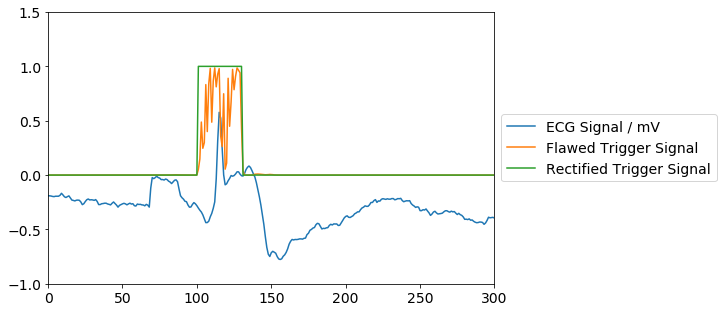

In [7]:
import matplotlib.pyplot as plt
from raccoon.utils.triggerutils import discretize, remove_ripple

plt.rcParams.update({'font.size': 14})

fig_wide, ax_wide = plt.subplots()
fig_wide.set_size_inches(10, 5)

idx = 2

ax_wide.plot(noisy_records[idx].p_signal.T[0], label="ECG Signal / mV")
ax_wide.plot(trigger_signals[idx], label="Flawed Trigger Signal")
ax_wide.plot(
    list(remove_ripple(discretize(trigger_signals[idx], threshold=0.05), tolerance=10)),
    label="Rectified Trigger Signal")
xstart = 0
xstride = 300
ax_wide.set_xlim(xstart, xstart+xstride)
ax_wide.set_ylim(-1, 1.5)

# Shrink current axis by 20%
box = ax_wide.get_position()
ax_wide.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax_wide.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

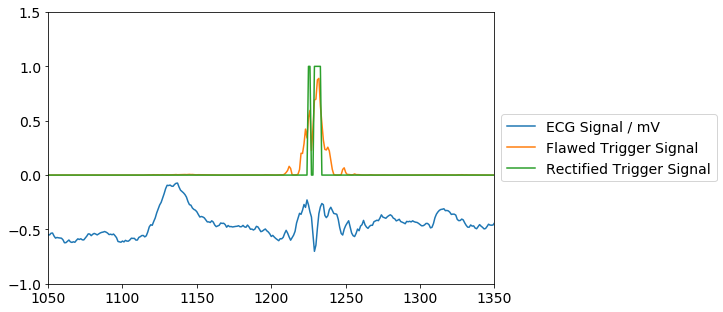

In [8]:
import matplotlib.pyplot as plt
from raccoon.utils.triggerutils import discretize, remove_ripple

plt.rcParams.update({'font.size': 14})

fig_narrow, ax_narrow = plt.subplots()
fig_narrow.set_size_inches(10, 5)

idx = 1

ax_narrow.plot(noisy_records[idx].p_signal.T[0], label="ECG Signal / mV")
ax_narrow.plot(trigger_signals[idx], label="Flawed Trigger Signal")
ax_narrow.plot(
    list(remove_ripple(discretize(trigger_signals[idx], threshold=0.5), tolerance=100)),
    label="Rectified Trigger Signal")
xstart = 1050
xstride = 300
ax_narrow.set_xlim(xstart, xstart+xstride)
ax_narrow.set_ylim(-1, 1.5)

# Shrink current axis by 20%
box = ax_narrow.get_position()
ax_narrow.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax_narrow.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [9]:
save = True 

if save:
    fig_wide.savefig(
        '../generated/figures/rts_too_wide.pdf',
        format='pdf',
        bbox_inches = 'tight',
        pad_inches = 0.1)
    fig_narrow.savefig(
        '../generated/figures/rts_too_narrow.pdf',
        format='pdf',
        bbox_inches = 'tight',
        pad_inches = 0.1)